In [1]:
%%HTML
<style>
    div#notebook-container    { width: 100%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>

# 環境構築

### Chapter 2.3.2

Google Colaboratoryを使用
<a href="https://colab.research.google.com/github/JapanExchangeGroup/J-Quants-Tutorial/blob/main/handson/Chapter02/20210121-chapter02-tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Chapter 2.3.3

以下の手順で環境構築して、dockerで起動したjupyter notebook で作業しています。
```
cd handson/

# データ配置先のディレクトリを作成
# handson/data_dirにデータをダウンロードしてきて配置しています。
mkdir data_dir

# dockerでjupyter notebookを起動します。(初回実行時は約2G程度コンテナイメージをダウンロードします。)
# データ配置先のディレクトリを /path/to としてマウントしています。
# 学習済みモデル提出用のディレクトリ (handson/Chapter02/archive) を /opt/ml としてマウントしています。
# jupyter notebook作業用に handson ディレクトリを /notebook としてマウントしています。
# jupyter notebook は port 8888でtokenとpasswordを空にして、vscode のjupyter pluginからアクセスできるように xsrf 対策を無効化しています。
docker run --name tutorial -v ${PWD}/data_dir:/path/to -v ${PWD}/Chapter02/archive:/opt/ml -v ${PWD}:/notebook -e PYTHONPATH=/opt/ml/src -p8888:8888 --rm -it continuumio/anaconda3:2019.03 jupyter notebook --ip 0.0.0.0 --allow-root --no-browser --no-mathjax --NotebookApp.disable_check_xsrf=True  --NotebookApp.token='' --NotebookApp.password='' /notebook

# ブラウザで以下のURLにアクセスしてjupyter notebookの画面が表示されていて、本チュートリアル用のnotebookが表示されていることを確認します。
http://localhost:8888/
```

### Chapter 2.3.4

In [2]:
# shap用にg++とgccをインストールします
! apt-get update
! apt-get install -y --no-install-recommends g++ gcc

# 必要なライブラリをインストールします
! pip install shap==0.37.0 slicer==0.0.3 xgboost==1.3.0.post0

Ign:1 http://deb.debian.org/debian stretch InRelease
Get:2 http://security.debian.org/debian-security stretch/updates InRelease [53.0 kB]
Get:3 http://deb.debian.org/debian stretch-updates InRelease [93.6 kB]
Get:4 http://deb.debian.org/debian stretch Release [118 kB]         
Get:5 http://security.debian.org/debian-security stretch/updates/main amd64 Packages [652 kB]
Get:6 http://deb.debian.org/debian stretch Release.gpg [2410 B]                
Get:7 http://deb.debian.org/debian stretch-updates/main amd64 Packages.diff/Index [14.5 kB]
Get:8 http://deb.debian.org/debian stretch/main amd64 Packages [7080 kB]
Get:9 http://deb.debian.org/debian stretch-updates/main amd64 Packages [2596 B]
Fetched 8016 kB in 5s (1526 kB/s)                         
Reading package lists... Done
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  binutils cpp cpp-6 g++-6 gcc-6 libasan3 libatomic1 libc-dev-bin

Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../22-libc6-dev_2.24-11+deb9u4_amd64.deb ...
Unpacking libc6-dev:amd64 (2.24-11+deb9u4) ...
Selecting previously unselected package libstdc++-6-dev:amd64.
Preparing to unpack .../23-libstdc++-6-dev_6.3.0-18+deb9u1_amd64.deb ...
Unpacking libstdc++-6-dev:amd64 (6.3.0-18+deb9u1) ...
Selecting previously unselected package g++-6.
Preparing to unpack .../24-g++-6_6.3.0-18+deb9u1_amd64.deb ...
Unpacking g++-6 (6.3.0-18+deb9u1) ...
Selecting previously unselected package g++.
Preparing to unpack .../25-g++_4%3a6.3.0-4_amd64.deb ...
Unpacking g++ (4:6.3.0-4) ...
Setting up libquadmath0:amd64 (6.3.0-18+deb9u1) ...
Setting up libgomp1:amd64 (6.3.0-18+deb9u1) ...
Setting up libatomic1:amd64 (6.3.0-18+deb9u1) ...
Setting up libcc1-0:amd64 (6.3.0-18+deb9u1) ...
Setting up libasan3:amd64 (6.3.0-18+deb9u1) ...
Setting up libcilkrts5:amd64 (6.3.0-18+deb9u1) ...
Setting up libubsan0:amd64 (6.3.0-18+deb9u1) ...
Setting up lib

# Imports & Load Data

作業に必要なライブラリをインポートして、
以下のデータを読み込みます。

- stock_price     : 株価情報
- stock_list      : 銘柄情報 
- stock_fin       : 財務諸表
- stock_labels    : 目的変数

本チュートリアルでは `stock_fin` および `stock_price` を使用するため、 `stock_fin_price` は読み込まずに進めます。

### Chapter 2.3.5

In [3]:
import os
import pickle
import sys
import warnings
from glob import glob

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import xgboost
from scipy.stats import spearmanr
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm.auto import tqdm

In [4]:
if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')

In [5]:
# 表示用の設定を変更します
%matplotlib inline
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100
pd.options.display.width = 120

### CHpater 2.3.7

In [6]:
# python 3.7.3であることを確認します (Colab環境では3.6.9となります)
print(sys.version)

3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]


### Chapter 2.4

In [7]:
# データセット保存先ディレクトリ
if 'google.colab' in sys.modules:
    dataset_dir="/content/drive/MyDrive/JPX_competition"
else:
    dataset_dir="/path/to"

# 読み込むファイルを定義します。
inputs = {
    "stock_list": f"{dataset_dir}/stock_list.csv.gz",
    "stock_price": f"{dataset_dir}/stock_price.csv.gz",
    "stock_fin": f"{dataset_dir}/stock_fin.csv.gz",
    # "stock_fin_price": f"{dataset_dir}/stock_fin_price.csv.gz",
    "stock_labels": f"{dataset_dir}/stock_labels.csv.gz",
}

# ファイルを読み込みます
dfs = {}
for k, v in inputs.items():
    print(k)
    dfs[k] = pd.read_csv(v)
    # DataFrameのindexを設定します。
    if k == "stock_price":
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "EndOfDayQuote Date"]
        )
        dfs[k].set_index("datetime", inplace=True)
    elif k in ["stock_fin", "stock_fin_price", "stock_labels"]:
        dfs[k].loc[:, "datetime"] = pd.to_datetime(
            dfs[k].loc[:, "base_date"]
        )
        dfs[k].set_index("datetime", inplace=True)

stock_list
stock_price
stock_fin
stock_labels


In [8]:
# 必要に応じてアンコメントしてください。

# # Timestamp型に変換する列を定義します。
# # ファイル名: {列名: 日付文字列フォーマット}
# datetime_mapping = {
#     "stock_list": {
#         "Effective Date": "%Y%m%d",
#         "IssuedShareEquityQuote ModifyDate": "%Y/%m/%d"
#     },
#     "stock_price": {
#         "EndOfDayQuote Date": "%Y/%m/%d",
#         "EndOfDayQuote PreviousCloseDate": "%Y/%m/%d",
#         "EndOfDayQuote PreviousExchangeOfficialCloseDate": "%Y/%m/%d",
#     },
#     "stock_fin": {
#         "base_date": "%Y/%m/%d",
#         "Result_FinancialStatement ModifyDate": "%Y/%m/%d",
#         "Forecast_FinancialStatement ModifyDate": "%Y/%m/%d",
#         "Result_Dividend ModifyDate": "%Y/%m/%d",
#         "Forecast_Dividend ModifyDate": "%Y/%m/%d",
#     },
#     "stock_labels": {
#         "base_date": "%Y-%m-%d",
#         # "label_date_5": "%Y-%m-%d",
#         "label_date_10": "%Y-%m-%d",
#         "label_date_20": "%Y-%m-%d",
#     }
# }
# # 読み込んだデータの日付列をpd.Timestamp型に変更します
# for k, datetime_cols in datetime_mapping.items():
#     for col, format in datetime_cols.items():
#         dfs[k][col] = pd.to_datetime(dfs[k][col], format=format)

In [9]:
for k in inputs.keys():
    print(k)
    print(dfs[k].info())
    print(dfs[k].head(1).T)

stock_list
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3711 entries, 0 to 3710
Data columns (total 14 columns):
prediction_target                            3711 non-null bool
Effective Date                               3711 non-null int64
Local Code                                   3711 non-null int64
Name (English)                               3711 non-null object
Section/Products                             3711 non-null object
33 Sector(Code)                              3711 non-null int64
33 Sector(name)                              3711 non-null object
17 Sector(Code)                              3711 non-null int64
17 Sector(name)                              3711 non-null object
Size Code (New Index Series)                 3711 non-null object
Size (New Index Series)                      3711 non-null object
IssuedShareEquityQuote AccountingStandard    3708 non-null object
IssuedShareEquityQuote ModifyDate            3708 non-null object
IssuedShareEquityQuote IssuedS

# Data Exploring

### Chapter 2.2.1の表

In [10]:
print(dfs["stock_list"].shape)
dfs["stock_list"].head(3)

(3711, 14)


,prediction_target,Effective Date,Local Code,Name (English),Section/Products,33 Sector(Code),33 Sector(name),17 Sector(Code),17 Sector(name),Size Code (New Index Series),Size (New Index Series),IssuedShareEquityQuote AccountingStandard,IssuedShareEquityQuote ModifyDate,IssuedShareEquityQuote IssuedShare
0,True,20201230,1301,"KYOKUYO CO.,LTD.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,7,TOPIX Small 2,ConsolidatedJP,2020/11/06,10928283.0
1,True,20201230,1332,"Nippon Suisan Kaisha,Ltd.",First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/05,312430277.0
2,True,20201230,1333,Maruha Nichiro Corporation,First Section (Domestic),50,"Fishery, Agriculture and Forestry",1,FOODS,4,TOPIX Mid400,ConsolidatedJP,2020/11/02,52656910.0


### Chapter 2.2.2の表

In [11]:
print(dfs["stock_price"].shape)
dfs["stock_price"].head(3)

(4225441, 16)


,Local Code,EndOfDayQuote Date,EndOfDayQuote Open,EndOfDayQuote High,EndOfDayQuote Low,EndOfDayQuote Close,EndOfDayQuote ExchangeOfficialClose,EndOfDayQuote Volume,EndOfDayQuote CumulativeAdjustmentFactor,EndOfDayQuote PreviousClose,EndOfDayQuote PreviousCloseDate,EndOfDayQuote PreviousExchangeOfficialClose,EndOfDayQuote PreviousExchangeOfficialCloseDate,EndOfDayQuote ChangeFromPreviousClose,EndOfDayQuote PercentChangeFromPreviousClose,EndOfDayQuote VWAP
datetime,,,,,,,,,,,,,,,,
2016-01-04,1301,2016/01/04,2800.0,2820.0,2740.0,2750.0,2750.0,32000.0,0.1,2770.0,2015/12/30,2770.0,2015/12/30,-20.0,-0.722,2778.250
2016-01-05,1301,2016/01/05,2750.0,2780.0,2750.0,2760.0,2760.0,20100.0,0.1,2750.0,2016/01/04,2750.0,2016/01/04,10.0,0.364,2761.990
2016-01-06,1301,2016/01/06,2760.0,2770.0,2740.0,2760.0,2760.0,15000.0,0.1,2760.0,2016/01/05,2760.0,2016/01/05,0.0,0.000,2758.867


### Chapter 2.2.3の表

In [12]:
print(dfs["stock_fin"].shape)
dfs["stock_fin"].head(3)

(81797, 44)


,base_date,Local Code,Result_FinancialStatement AccountingStandard,Result_FinancialStatement FiscalPeriodEnd,Result_FinancialStatement ReportType,Result_FinancialStatement FiscalYear,Result_FinancialStatement ModifyDate,Result_FinancialStatement CompanyType,Result_FinancialStatement ChangeOfFiscalYearEnd,Result_FinancialStatement NetSales,Result_FinancialStatement OperatingIncome,Result_FinancialStatement OrdinaryIncome,Result_FinancialStatement NetIncome,Result_FinancialStatement TotalAssets,Result_FinancialStatement NetAssets,Result_FinancialStatement CashFlowsFromOperatingActivities,Result_FinancialStatement CashFlowsFromFinancingActivities,Result_FinancialStatement CashFlowsFromInvestingActivities,Forecast_FinancialStatement AccountingStandard,Forecast_FinancialStatement FiscalPeriodEnd,Forecast_FinancialStatement ReportType,Forecast_FinancialStatement FiscalYear,Forecast_FinancialStatement ModifyDate,Forecast_FinancialStatement CompanyType,Forecast_FinancialStatement ChangeOfFiscalYearEnd,Forecast_FinancialStatement NetSales,Forecast_FinancialStatement OperatingIncome,Forecast_FinancialStatement OrdinaryIncome,Forecast_FinancialStatement NetIncome,Result_Dividend FiscalPeriodEnd,Result_Dividend ReportType,Result_Dividend FiscalYear,Result_Dividend ModifyDate,Result_Dividend RecordDate,Result_Dividend DividendPayableDate,Result_Dividend QuarterlyDividendPerShare,Result_Dividend AnnualDividendPerShare,Forecast_Dividend FiscalPeriodEnd,Forecast_Dividend ReportType,Forecast_Dividend FiscalYear,Forecast_Dividend ModifyDate,Forecast_Dividend RecordDate,Forecast_Dividend QuarterlyDividendPerShare,Forecast_Dividend AnnualDividendPerShare
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-04,2016/01/04,2753,ConsolidatedJP,2015/12,Q3,2016.0,2016/01/04,GB,False,22354.0,2391.0,2466.0,1645.0,21251.0,16962.0,NaN,NaN,NaN,ConsolidatedJP,2016/03,Annual,2016.0,2016/01/04,GB,False,30500.0,3110.0,3200.0,2130.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,45.0,90.0
2016-01-04,2016/01/04,3353,ConsolidatedJP,2015/11,Q3,2016.0,2016/01/04,GB,False,21550.0,1038.0,1053.0,697.0,24949.0,7145.0,NaN,NaN,NaN,ConsolidatedJP,2016/02,Annual,2016.0,2016/01/04,GB,False,27800.0,1320.0,1310.0,840.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/02,Annual,2016.0,2016/01/04,2016/02/29,32.5,65.0
2016-01-04,2016/01/04,4591,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NonConsolidated,2016/03,Annual,2016.0,2016/01/04,GB,False,119.0,-474.0,-451.0,-452.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016/03,Annual,2016.0,2016/01/04,2016/03/31,0.0,0.0


### Chapter 2.2.4の表

In [13]:
# 必要に応じてアンコメントしてください

# print(dfs["stock_fin_price"].shape)
# dfs["stock_fin_price"].head()

### Chapter 2.2.5の表

In [14]:
print(dfs["stock_labels"].shape)
dfs["stock_labels"].head(3)

(4225441, 11)


,base_date,Local Code,label_date_5,label_high_5,label_low_5,label_date_10,label_high_10,label_low_10,label_date_20,label_high_20,label_low_20
datetime,,,,,,,,,,,
2016-01-04,2016-01-04,1301,2016-01-12,0.01091,-0.04000,2016-01-19,0.01091,-0.05455,2016-02-02,0.01091,-0.08727
2016-01-05,2016-01-05,1301,2016-01-13,0.00362,-0.04348,2016-01-20,0.00362,-0.07609,2016-02-03,0.00362,-0.09058
2016-01-06,2016-01-06,1301,2016-01-14,0.00000,-0.05072,2016-01-21,0.00000,-0.08696,2016-02-04,0.00362,-0.09058


# Visualization

### Chapter 2.5.1 売上高、営業利益、純利益、純資産及びその決算期の間の関係について可視化

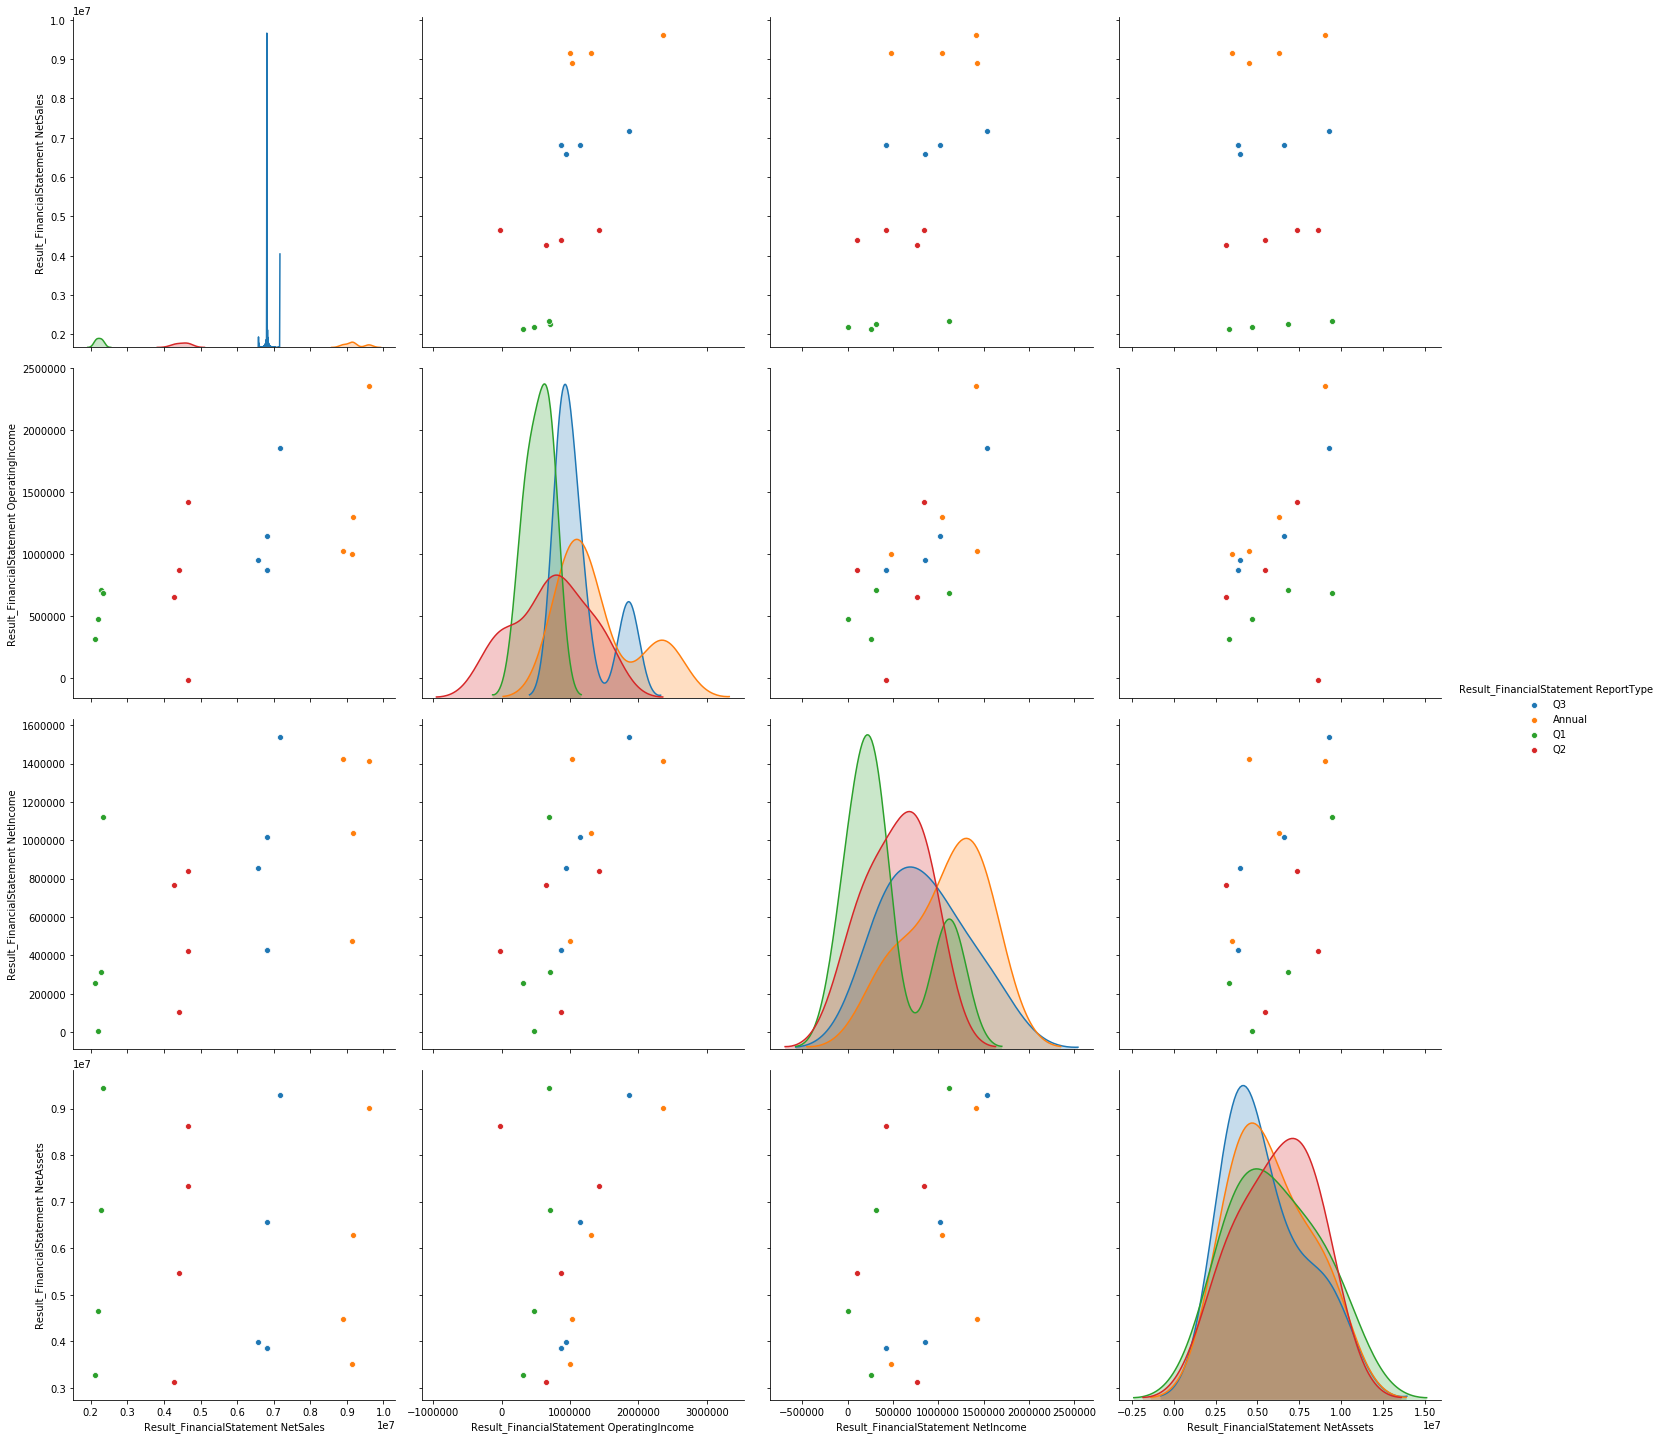

In [15]:
# stock_finの読み込み
fin = dfs["stock_fin"]

# 銘柄コード9984にデータを絞る
code = 9984
fin_data = fin[fin["Local Code"] == code]

# 2019年までの値を表示
fin_data = fin_data[:"2019"]

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# プロット
sns.pairplot(fin_data[columns], hue="Result_FinancialStatement ReportType", height=5)

### Chapter 2.5.1 複数銘柄のファンダメンタル情報の比較

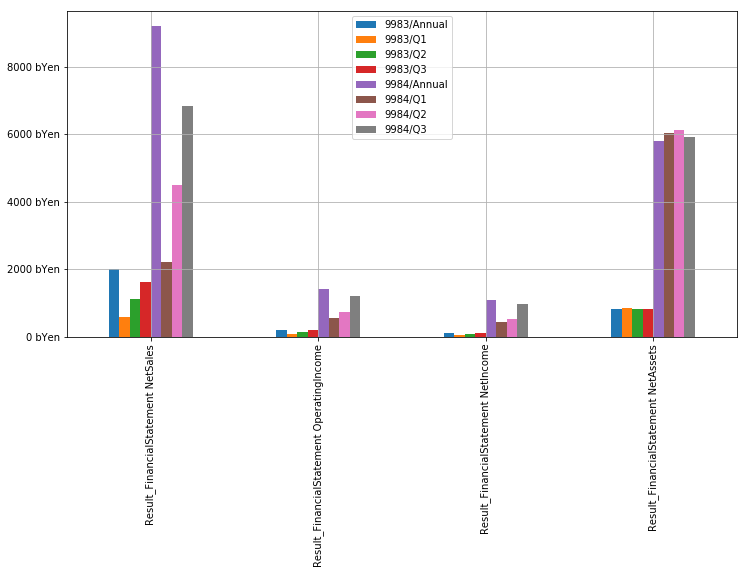

In [16]:
# stock_finの読み込み
fin = dfs["stock_fin"]

# 銘柄コード9984と9983を比較する
codes = [9984, 9983]

multi_df = dict()

# プロット対象を定義
columns = [
    "Result_FinancialStatement NetSales",  # 売上高
    "Result_FinancialStatement OperatingIncome",  # 営業利益
    "Result_FinancialStatement NetIncome",  # 純利益
    "Result_FinancialStatement NetAssets",  # 純資産
    "Result_FinancialStatement ReportType"  # 決算期
]

# 比較対象の銘柄コード毎に処理
for code in codes:
    # 特定の銘柄コードに絞り込み
    fin_data = fin[fin["Local Code"] == code]
    # 2019年までの値を表示
    fin_data = fin_data[:"2019"].copy()
    # 重複を排除
    fin_data.drop_duplicates(
        subset=[
            "Local Code",
            "Result_FinancialStatement FiscalYear",
            "Result_FinancialStatement ReportType"
        ],
        keep="last", inplace=True)
    # プロット対象のカラムを取得
    _fin_data = fin_data[columns]
    # 決算期毎の平均を取得
    multi_df[code] = _fin_data[columns].groupby("Result_FinancialStatement ReportType").mean()

# 銘柄毎に処理していたものを結合
multi_df = pd.concat(multi_df)
# 凡例を調整
multi_df.set_index(multi_df.index.map(lambda t: f"{t[0]}/{t[1]}"), inplace=True)
# プロット
ax = multi_df.T.plot(kind="bar", figsize=(12, 6), grid=True)
# Y軸のラベルを調整
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "{} bYen".format(int(x / 1_000))))

### Chapter 2.5.2 株価の終値の動き

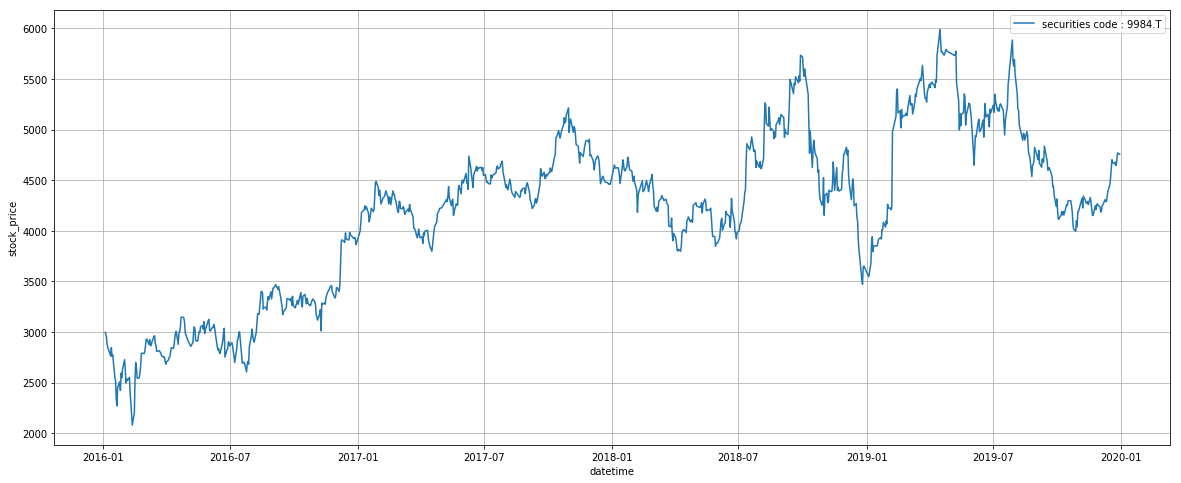

In [17]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"]

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

ax.plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label=f"securities code : {code}.T")
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

### Chapter 2.5.3 移動平均

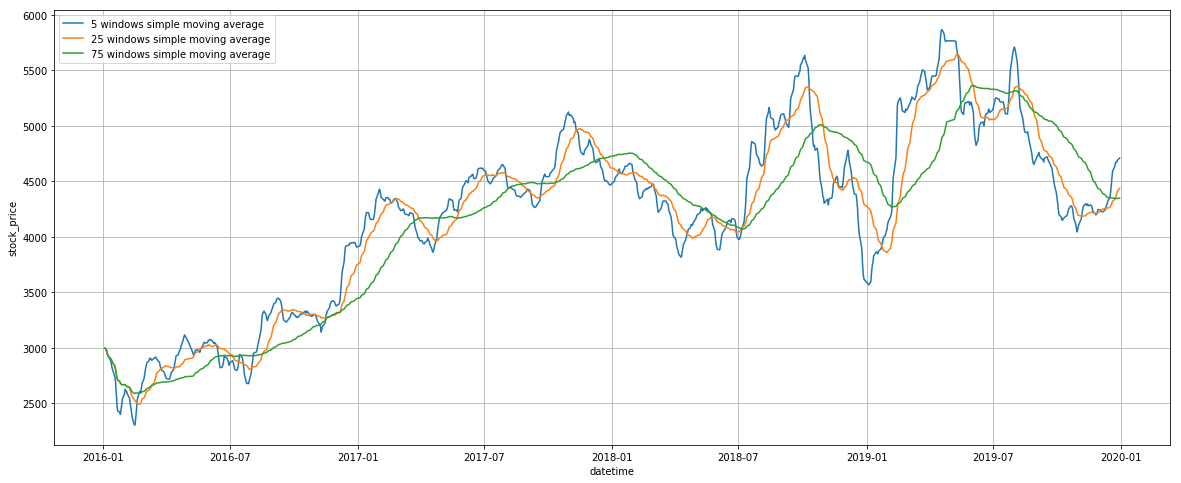

In [18]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日の移動平均を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("stock_price")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

### Chapter 2.5.4 価格変化率

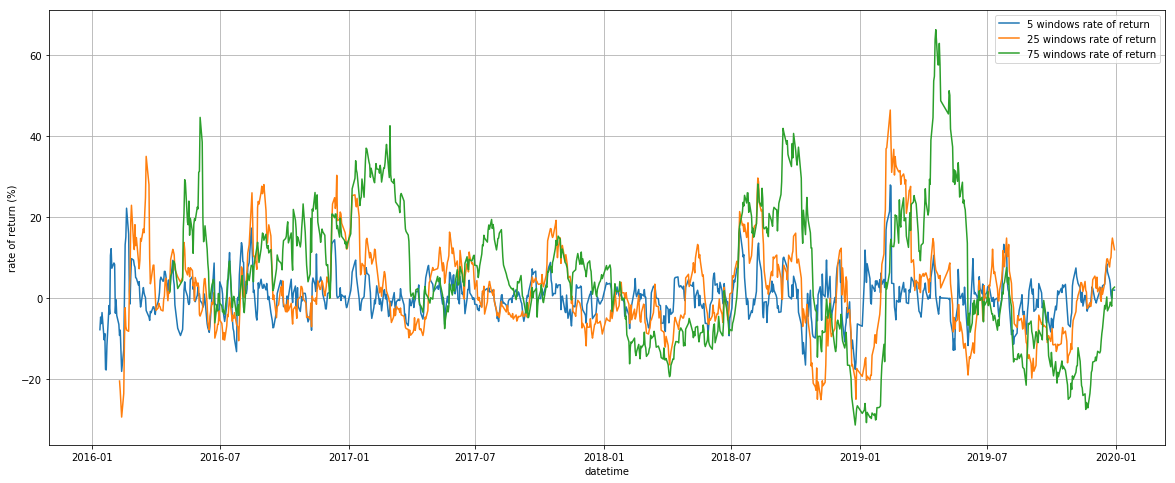

In [19]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日の価格変化率を算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("rate of return (%)")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

### Chapter 2.5.5 ヒストリカル・ボラティリティ

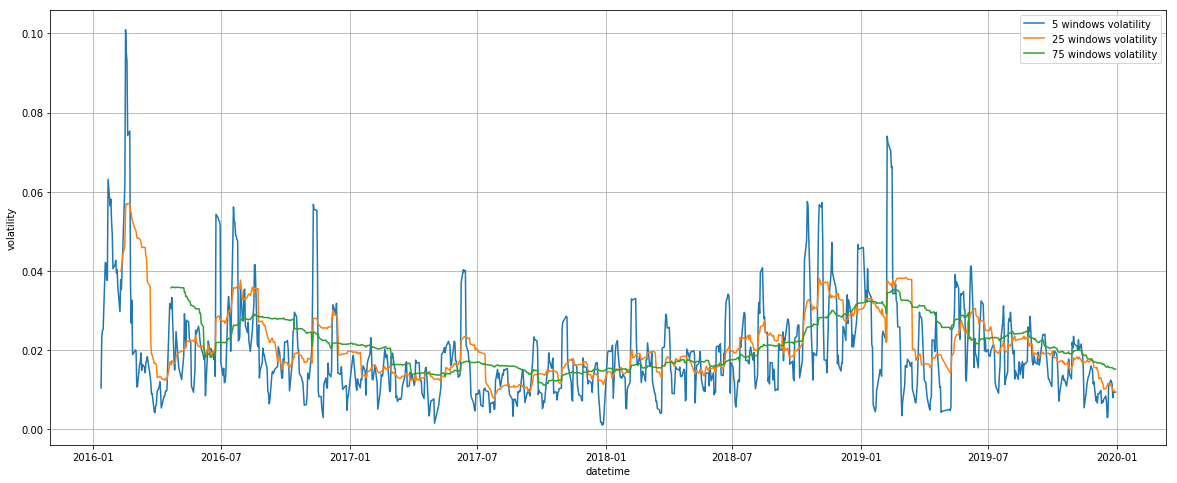

In [20]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日のヒストリカル・ボラティリティを算出
periods = [5, 25, 75]
cols = []
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    cols.append(col)

# プロット
fig, ax = plt.subplots(figsize=(20, 8))

for col in cols:
    ax.plot(price_data[col], label=col)
ax.set_ylabel("volatility")
ax.set_xlabel("datetime")
ax.grid(True)
ax.legend()

### Chapter 2.5.6 複数のデータを同時にプロット

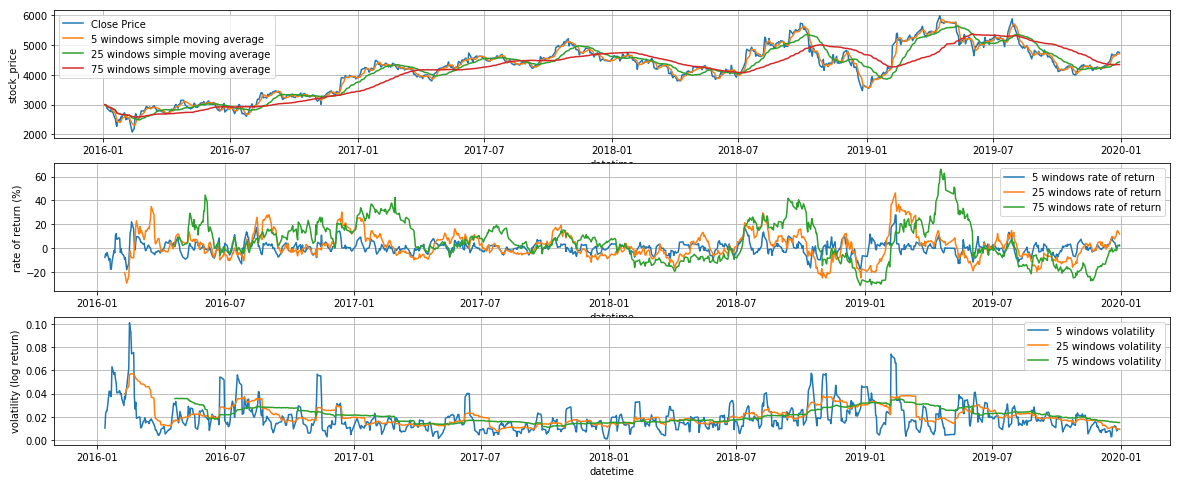

In [21]:
# stock_priceの読み込み
price = dfs["stock_price"]

# 特定の銘柄コードに絞り込み
code = 9984
price_data = price[price["Local Code"] == code]
# 2019年までの値を表示
price_data = price_data[:"2019"].copy()

# 5日、25日、75日を対象に値を算出
periods = [5, 25, 75]
ma_cols = []
# 移動平均線
for period in periods:
    col = "{} windows simple moving average".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].rolling(period, min_periods=1).mean()
    ma_cols.append(col)

return_cols = []
# 価格変化率
for period in periods:
    col = "{} windows rate of return".format(period)
    price_data[col] = price_data["EndOfDayQuote ExchangeOfficialClose"].pct_change(period) * 100
    return_cols.append(col)

vol_cols = []
# ヒストリカル・ボラティリティ
for period in periods:
    col = "{} windows volatility".format(period)
    price_data[col] = np.log(price_data["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(period).std()
    vol_cols.append(col)

# プロット
fig, ax = plt.subplots(nrows=3 ,figsize=(20, 8))

ax[0].plot(price_data["EndOfDayQuote ExchangeOfficialClose"], label="Close Price")

for col in ma_cols:
    ax[0].plot(price_data[col], label=col)

for col in return_cols:
    ax[1].plot(price_data[col], label=col)

for col in vol_cols:
    ax[2].plot(price_data[col], label=col)

ax[0].set_ylabel("stock_price")
ax[1].set_ylabel("rate of return (%)")
ax[2].set_ylabel("volatility (log return)")
for _ax in ax:
    _ax.set_xlabel("datetime")
    _ax.grid(True)
    _ax.legend()

### Chapter 2.6.2

(64421, 44)
base_date                                                         0
Local Code                                                        0
Result_FinancialStatement AccountingStandard                    239
Result_FinancialStatement FiscalPeriodEnd                       239
Result_FinancialStatement ReportType                            239
Result_FinancialStatement FiscalYear                            239
Result_FinancialStatement ModifyDate                            239
Result_FinancialStatement CompanyType                           239
Result_FinancialStatement ChangeOfFiscalYearEnd                 239
Result_FinancialStatement NetSales                              256
Result_FinancialStatement OperatingIncome                      2072
Result_FinancialStatement OrdinaryIncome                        308
Result_FinancialStatement NetIncome                             242
Result_FinancialStatement TotalAssets                           240
Result_FinancialStatement NetAssets 

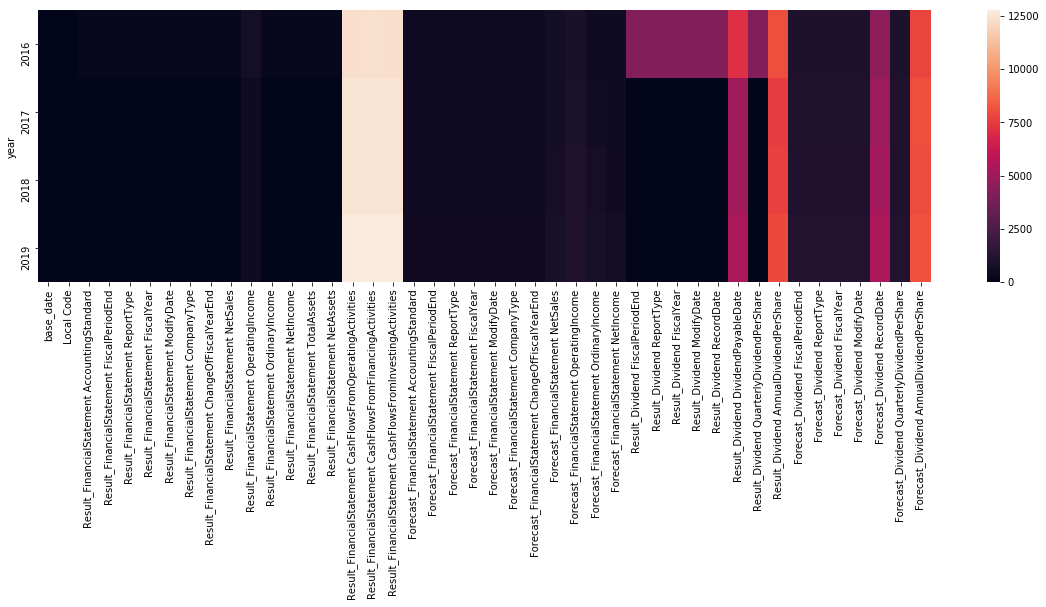

In [22]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"]

# 2019年までの値を表示
stock_fin = stock_fin[:"2019"]

# データ数の確認
print(stock_fin.shape)

# データの欠損値数を確認
print(stock_fin.isna().sum())

# 欠損値の数を年別に集計
stock_fin = stock_fin.isna()
stock_fin["year"] = stock_fin.index.year

# データの欠損値をプロット
fig, ax = plt.subplots(figsize=(20, 5))
sns.heatmap(stock_fin.groupby("year").agg("sum"), ax=ax)

In [23]:
# stock_finデータを読み込む
stock_fin = dfs["stock_fin"]

# 銘柄コード9984にデータを絞る
code = 9984
stock_fin = stock_fin[stock_fin["Local Code"] == code]

# float64型の列に絞り込み
fin_data = stock_fin.select_dtypes(include=["float64"])

# 欠損値を0でフィル
fin_data = fin_data.fillna(0)

In [24]:
fin_data.head(1).T

datetime,2016-02-10 00:00:00
Result_FinancialStatement FiscalYear,2016.0
Result_FinancialStatement NetSales,6810206.0
Result_FinancialStatement OperatingIncome,875322.0
Result_FinancialStatement OrdinaryIncome,918214.0
Result_FinancialStatement NetIncome,428972.0
Result_FinancialStatement TotalAssets,21497648.0
Result_FinancialStatement NetAssets,3855507.0
Result_FinancialStatement CashFlowsFromOperatingActivities,0.0
Result_FinancialStatement CashFlowsFromFinancingActivities,0.0
Result_FinancialStatement CashFlowsFromInvestingActivities,0.0


# Define features

1/2/3monthのリターンに加えて標準偏差、移動平均乖離率などの特徴量生成

※時刻は分析対象データを決算後翌営業日から一週間で価格データが存在していた銘柄のみにフィルタリング

### Chapter 2.7.3

In [25]:
# stock_priceデータを読み込む
price = dfs["stock_price"]

# 銘柄コード9984にデータを絞る
code = 9984
price_data = price[price["Local Code"] == code]

# 終値のみに絞る
feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]].copy()
# 終値の20営業日リターン
feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
# 終値の40営業日リターン
feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
# 終値の60営業日リターン
feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
# 終値の20営業日ボラティリティ
feats["volatility_1month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
)
# 終値の40営業日ボラティリティ
feats["volatility_2month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
)
# 終値の60営業日ボラティリティ
feats["volatility_3month"] = (
    np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
)
# 終値と20営業日の単純移動平均線の乖離
feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
)
# 終値と40営業日の単純移動平均線の乖離
feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
)
# 終値と60営業日の単純移動平均線の乖離
feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
    feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
)
# 欠損値処理
feats = feats.fillna(0)
# 元データのカラムを削除
feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

In [26]:
feats.head(1).T

datetime,2016-01-04 00:00:00
return_1month,0.0
return_2month,0.0
return_3month,0.0
volatility_1month,0.0
volatility_2month,0.0
volatility_3month,0.0
MA_gap_1month,0.0
MA_gap_2month,0.0
MA_gap_3month,0.0


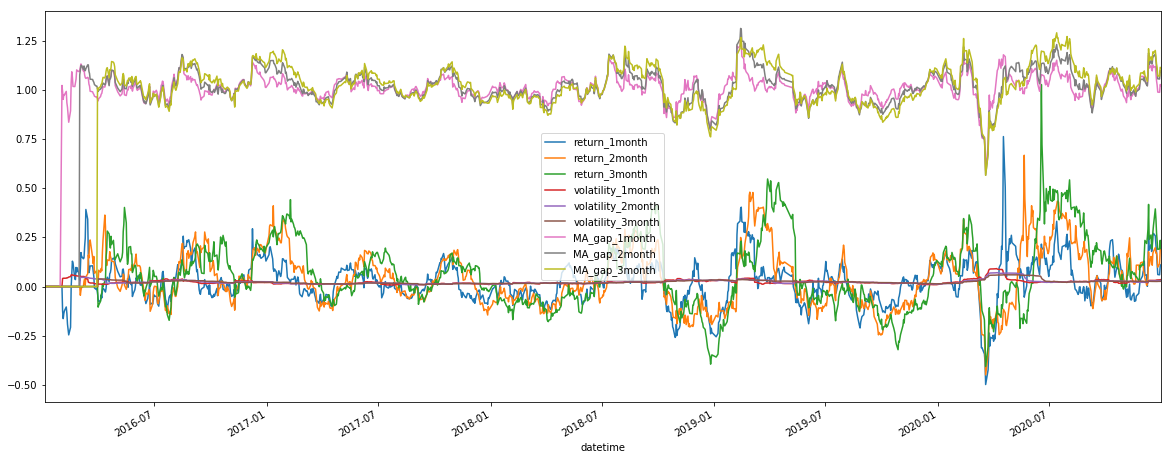

In [27]:
feats.plot(figsize=(20,8))

# バックテスト期間の設定

### Chapter 2.8.2

In [28]:
# データ分割期間を定義
TRAIN_END = "2017-12-31"
VAL_START = "2018-02-01"
VAL_END = "2018-12-01"
TEST_START = "2019-01-01"

# 特徴量の生成

### Chapter 2.9.1

In [29]:
def get_features_for_predict(dfs, code, start_dt="2015-01-01"):
    """
    Args:
        dfs (dict)  : dict of pd.DataFrame include stock_fin, stock_price
        code (int)  : A local code for a listed company
        start_dt (str): specify date range
    Returns:
        feature DataFrame (pd.DataFrame)
    """
    # stock_finデータを読み込み
    stock_fin = dfs["stock_fin"]

    # 特定の銘柄コードのデータに絞る
    fin_data = stock_fin[stock_fin["Local Code"] == code]
    # 特徴量の作成には過去60営業日のデータを使用しているため、
    # 予測対象日からバッファ含めて土日を除く過去90日遡った時点から特徴量を生成します
    n = 90
    # 特徴量の生成対象期間を指定
    fin_data = fin_data.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :]
    # fin_dataのnp.float64のデータのみを取得
    fin_data = fin_data.select_dtypes(include=["float64"])
    # 欠損値処理
    fin_feats = fin_data.fillna(0)

    # stock_priceデータを読み込む
    price = dfs["stock_price"]
    # 特定の銘柄コードのデータに絞る
    price_data = price[price["Local Code"] == code]
    # 終値のみに絞る
    feats = price_data[["EndOfDayQuote ExchangeOfficialClose"]]
    # 特徴量の生成対象期間を指定
    feats = feats.loc[pd.Timestamp(start_dt) - pd.offsets.BDay(n) :].copy()

    # 終値の20営業日リターン
    feats["return_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(20)
    # 終値の40営業日リターン
    feats["return_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(40)
    # 終値の60営業日リターン
    feats["return_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"].pct_change(60)
    # 終値の20営業日ボラティリティ
    feats["volatility_1month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(20).std()
    )
    # 終値の40営業日ボラティリティ
    feats["volatility_2month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(40).std()
    )
    # 終値の60営業日ボラティリティ
    feats["volatility_3month"] = (
        np.log(feats["EndOfDayQuote ExchangeOfficialClose"]).diff().rolling(60).std()
    )
    # 終値と20営業日の単純移動平均線の乖離
    feats["MA_gap_1month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(20).mean()
    )
    # 終値と40営業日の単純移動平均線の乖離
    feats["MA_gap_2month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(40).mean()
    )
    # 終値と60営業日の単純移動平均線の乖離
    feats["MA_gap_3month"] = feats["EndOfDayQuote ExchangeOfficialClose"] / (
        feats["EndOfDayQuote ExchangeOfficialClose"].rolling(60).mean()
    )
    # 欠損値処理
    feats = feats.fillna(0)
    # 元データのカラムを削除
    feats = feats.drop(["EndOfDayQuote ExchangeOfficialClose"], axis=1)

    # 財務データの特徴量とマーケットデータの特徴量のインデックスを合わせる
    feats = feats.loc[feats.index.isin(fin_feats.index)]
    fin_feats = fin_feats.loc[fin_feats.index.isin(feats.index)]

    # データを結合
    feats = pd.concat([feats, fin_feats], axis=1).dropna()

    # 欠損値処理を行います。
    feats = feats.replace([np.inf, -np.inf], 0)

    # 銘柄コードを設定
    feats["code"] = code

    # 生成対象日以降の特徴量に絞る
    feats = feats.loc[pd.Timestamp(start_dt) :]

    return feats

In [30]:
df = get_features_for_predict(dfs, 9984)
df.T

datetime,2016-02-10 00:00:00,2016-04-21 00:00:00,2016-05-10 00:00:00,2016-07-28 00:00:00,2016-11-07 00:00:00,2017-02-08 00:00:00,2017-05-10 00:00:00,2017-08-07 00:00:00,2017-11-06 00:00:00,2018-02-07 00:00:00,2018-05-09 00:00:00,2018-08-06 00:00:00,2018-11-05 00:00:00,2019-02-06 00:00:00,2019-05-09 00:00:00,2019-08-07 00:00:00,2019-11-06 00:00:00,2020-02-12 00:00:00,2020-04-13 00:00:00,2020-04-30 00:00:00,2020-05-18 00:00:00,2020-08-11 00:00:00,2020-10-23 00:00:00,2020-11-09 00:00:00
return_1month,-1.913212e-01,8.908766e-02,8.688554e-02,-7.610193e-02,-3.968613e-02,2.224838e-02,8.804402e-02,9.961943e-03,8.356941e-02,-5.596001e-02,1.203510e-01,1.374653e-01,-2.102032e-01,8.878024e-02,5.914718e-02,-4.413740e-03,4.902913e-02,1.390374e-01,1.158342e-01,2.606803e-01,4.547511e-02,1.112701e-02,1.489293e-01,1.229098e-02
return_2month,0.000000e+00,1.441458e-01,2.409844e-02,-1.417147e-01,-7.741374e-02,1.144764e-01,4.466859e-02,-4.780498e-02,1.592260e-01,-6.940874e-02,7.893497e-03,1.775059e-01,-1.119797e-01,-1.097317e-01,1.015737e-01,1.675649e-02,-8.101212e-02,3.389988e-01,-2.304874e-01,-8.942610e-02,2.591281e-01,2.268081e-01,6.656627e-02,2.476660e-01
return_3month,0.000000e+00,2.555166e-01,1.739812e-01,-1.038744e-01,6.066667e-02,4.418064e-01,-3.892833e-03,4.227793e-02,1.126650e-01,-1.333666e-01,-1.530847e-02,1.065103e-01,-1.693257e-01,-3.258260e-02,3.665405e-01,3.811906e-02,-1.688462e-01,3.455779e-01,-1.564571e-01,2.409372e-02,-1.624071e-01,4.041943e-01,6.576373e-02,1.438953e-01
volatility_1month,4.402584e-02,1.717726e-02,2.271106e-02,3.175834e-02,1.816612e-02,1.522609e-02,1.157811e-02,1.171816e-02,1.838358e-02,1.995841e-02,1.387375e-02,2.234456e-02,4.054193e-02,1.672133e-02,1.514235e-02,2.397602e-02,1.696050e-02,3.441563e-02,8.639982e-02,3.362599e-02,2.807880e-02,2.506267e-02,1.671309e-02,2.384297e-02
volatility_2month,0.000000e+00,1.705030e-02,1.818629e-02,3.062359e-02,1.717361e-02,1.409169e-02,1.290494e-02,1.194563e-02,1.601125e-02,1.687287e-02,1.634615e-02,2.083745e-02,3.290983e-02,2.824798e-02,1.593598e-02,2.228841e-02,1.804909e-02,2.717941e-02,6.703024e-02,6.833698e-02,6.368045e-02,2.546068e-02,2.740215e-02,2.594448e-02
volatility_3month,0.000000e+00,3.428422e-02,3.271347e-02,2.758085e-02,1.972693e-02,1.948615e-02,1.331634e-02,1.679778e-02,1.444113e-02,1.580369e-02,1.608024e-02,1.943844e-02,2.879765e-02,2.756937e-02,2.729567e-02,2.419688e-02,1.791320e-02,2.312453e-02,5.856385e-02,6.008750e-02,5.734101e-02,2.369026e-02,2.694665e-02,2.668409e-02
MA_gap_1month,9.107187e-01,1.071322e+00,1.008618e+00,9.588478e-01,9.694274e-01,1.012936e+00,1.066627e+00,9.912226e-01,9.996080e-01,9.540805e-01,1.044586e+00,1.007283e+00,9.445341e-01,1.052259e+00,1.014114e+00,9.641599e-01,1.033230e+00,1.196816e+00,1.109218e+00,1.066639e+00,1.010287e+00,9.711673e-01,1.026183e+00,1.015520e+00
MA_gap_2month,0.000000e+00,1.067462e+00,1.037082e+00,9.375874e-01,9.660428e-01,1.050702e+00,1.070177e+00,9.902299e-01,1.054210e+00,9.530104e-01,1.043655e+00,1.074974e+00,8.712824e-01,1.046151e+00,1.043537e+00,9.861688e-01,9.938260e-01,1.218323e+00,9.579964e-01,1.119096e+00,1.100513e+00,1.052475e+00,1.073177e+00,1.051756e+00
MA_gap_3month,0.000000e+00,1.110128e+00,1.066974e+00,9.219905e-01,9.633156e-01,1.115042e+00,1.051330e+00,1.002253e+00,1.079846e+00,9.376535e-01,1.019751e+00,1.101696e+00,8.690109e-01,1.006648e+00,1.073046e+00,9.971634e-01,9.581661e-01,1.260576e+00,9.266409e-01,1.031623e+00,1.043319e+00,1.123141e+00,1.079417e+00,1.073711e+00
Result_FinancialStatement FiscalYear,2.016000e+03,2.016000e+03,2.016000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2.017000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.018000e+03,2.019000e+03,2.019000e+03,2.019000e+03,2.019000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.020000e+03,2.021000e+03,2.021000e+03,2.021000e+03


# 目的変数の生成

### Chapter 2.9.2

In [31]:
def get_features_and_label(dfs, codes, feature, label):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
        codes  (array) : target codes
        feature (pd.DataFrame): features
        label (str) : label column name
    Returns:
        train_X (pd.DataFrame): training data
        train_y (pd.DataFrame): label for train_X
        val_X (pd.DataFrame): validation data
        val_y (pd.DataFrame): label for val_X
        test_X (pd.DataFrame): test data
        test_y (pd.DataFrame): label for test_X
    """
    # 分割データ用の変数を定義
    trains_X, vals_X, tests_X = [], [], []
    trains_y, vals_y, tests_y = [], [], []

    # 銘柄コード毎に特徴量を作成
    for code in tqdm(codes):
        # 特徴量取得
        feats = feature[feature["code"] == code]

        # stock_labelデータを読み込み
        stock_labels = dfs["stock_labels"]
        # 特定の銘柄コードのデータに絞る
        stock_labels = stock_labels[stock_labels["Local Code"] == code]

        # 特定の目的変数に絞る
        labels = stock_labels[label].copy()
        # nanを削除
        labels.dropna(inplace=True)

        if feats.shape[0] > 0 and labels.shape[0] > 0:
            # 特徴量と目的変数のインデックスを合わせる
            labels = labels.loc[labels.index.isin(feats.index)]
            feats = feats.loc[feats.index.isin(labels.index)]
            labels.index = feats.index

            # データを分割
            _train_X = feats[: TRAIN_END]
            _val_X = feats[VAL_START : VAL_END]
            _test_X = feats[TEST_START :]

            _train_y = labels[: TRAIN_END]
            _val_y = labels[VAL_START : VAL_END]
            _test_y = labels[TEST_START :]

            # データを配列に格納 (後ほど結合するため)
            trains_X.append(_train_X)
            vals_X.append(_val_X)
            tests_X.append(_test_X)

            trains_y.append(_train_y)
            vals_y.append(_val_y)
            tests_y.append(_test_y)
    # 銘柄毎に作成した説明変数データを結合します。
    train_X = pd.concat(trains_X)
    val_X = pd.concat(vals_X)
    test_X = pd.concat(tests_X)
    # 銘柄毎に作成した目的変数データを結合します。
    train_y = pd.concat(trains_y)
    val_y = pd.concat(vals_y)
    test_y = pd.concat(tests_y)

    return train_X, train_y, val_X, val_y, test_X, test_y

In [32]:
# 対象銘柄コードを定義
codes = [9984]
# 対象の目的変数を定義
label = "label_high_20"
# 特徴量を取得
feat = get_features_for_predict(dfs, codes[0])
# 特徴量と目的変数を一致させて、データを分割
ret = get_features_and_label(dfs, codes, feat, label)
for v in ret:
    print(v.T)


datetime                                              2016-02-10    2016-04-21    2016-05-10    2016-07-28  \
return_1month                                      -1.913212e-01  8.908766e-02  8.688554e-02 -7.610193e-02   
return_2month                                       0.000000e+00  1.441458e-01  2.409844e-02 -1.417147e-01   
return_3month                                       0.000000e+00  2.555166e-01  1.739812e-01 -1.038744e-01   
volatility_1month                                   4.402584e-02  1.717726e-02  2.271106e-02  3.175834e-02   
volatility_2month                                   0.000000e+00  1.705030e-02  1.818629e-02  3.062359e-02   
volatility_3month                                   0.000000e+00  3.428422e-02  3.271347e-02  2.758085e-02   
MA_gap_1month                                       9.107187e-01  1.071322e+00  1.008618e+00  9.588478e-01   
MA_gap_2month                                       0.000000e+00  1.067462e+00  1.037082e+00  9.375874e-01   
MA_gap_3m

In [33]:
def get_codes(dfs):
    """
    Args:
        dfs (dict[pd.DataFrame]): loaded data
    Returns:
        array: list of stock codes
    """
    stock_list = dfs["stock_list"].copy()
    # 予測対象の銘柄コードを取得
    codes = stock_list[stock_list["prediction_target"] == True][
        "Local Code"
    ].values
    return codes

In [34]:
# 対象の目的変数を定義
if 'google.colab' in sys.modules:
    labels = {
        "label_high_20",
        "label_low_20",
    }
else:
    labels = {
        "label_high_5",
        "label_high_10",
        "label_high_20",
        "label_low_5",
        "label_low_10",
        "label_low_20",
    }

# 目的変数毎にデータを保存するための変数
train_X, val_X, test_X = {}, {}, {}
train_y, val_y, test_y = {}, {}, {}

# 予測対象銘柄を取得
codes = get_codes(dfs)

# 特徴量を作成
buff = []
for code in tqdm(codes):
    feat = get_features_for_predict(dfs, code)
    buff.append(feat)
feature = pd.concat(buff)

# 目的変数毎に処理
for label in tqdm(labels):
    # 特徴量と目的変数を取得
    _train_X, _train_y, _val_X, _val_y, _test_X, _test_y = get_features_and_label(dfs, codes, feature, label)
    # 目的変数をキーとして値を保存
    train_X[label] = _train_X
    val_X[label] = _val_X
    test_X[label] = _test_X
    train_y[label] = _train_y
    val_y[label] = _val_y
    test_y[label] = _test_y

# Create Model

### Chapter 2.9.3

In [35]:
# 目的変数を指定
label = "label_high_20"
# モデルの初期化
pred_model = RandomForestRegressor(random_state=0)
# モデルの学習
pred_model.fit(train_X[label], train_y[label])

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

# Predict

### Chapter 2.10.1

In [36]:
# モデルを定義
models = {
    "rf": RandomForestRegressor,
}

# モデルを選択
model = "rf"

# 目的変数を指定
label = "label_high_20"

# 特徴量グループを定義　
# ファンダメンタル
fundamental_cols = dfs["stock_fin"].select_dtypes("float64").columns
fundamental_cols = fundamental_cols[fundamental_cols != "Result_Dividend DividendPayableDate"]
fundamental_cols = fundamental_cols[fundamental_cols != "Local Code"]
# 価格変化率
returns_cols = [x for x in train_X[label].columns if "return" in x]
# テクニカル
technical_cols = [x for x in train_X[label].columns if (x not in fundamental_cols) and (x != "code")]
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}
# 特徴量グループを指定
col = "fundamental_only"

# 学習
pred_model = models[model](random_state=0)
pred_model.fit(train_X[label][columns[col]].values, train_y[label])

# 予測
result = {}
result[label] = pd.DataFrame(
    pred_model.predict(val_X[label][columns[col]]), columns=["predict"]
)

# 予測結果に日付と銘柄コードを追加
result[label]["datetime"] = val_X[label][columns[col]].index
result[label]["code"] = val_X[label]["code"].values

# 予測の符号を取得
result[label]["predict_dir"] = np.sign(result[label]["predict"])

# 実際の値を追加
result[label]["actual"] = val_y[label].values

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


# Submit Model

In [37]:
model_path = os.path.join(os.path.dirname("__file__"), "archive/model")
# tag::save_model[]
# モデル保存先ディレクトリを作成
os.makedirs(model_path, exist_ok=True)
with open(os.path.join(model_path, f"my_model_{label}.pkl"), "wb") as f:
    # モデルをpickle形式で保存
    pickle.dump(model, f)

# 予測結果の可視化

### Chapter 2.10.2

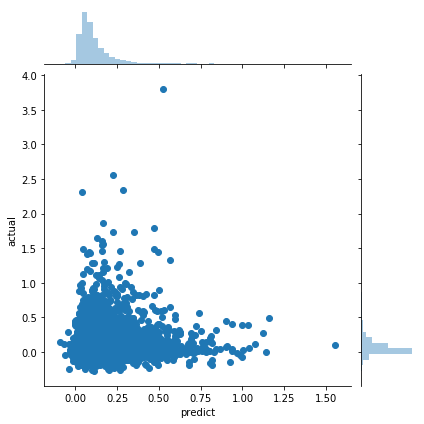

In [38]:
sns.jointplot(data=result[label], x="predict", y="actual")

In [39]:
result[label].loc[:, ["predict", "actual"]].corr()

,predict,actual
predict,1.000000,0.144192
actual,0.144192,1.000000


# 重要度

### Chapter 2.11.1

Text(0.5, 0, 'Random Forest Feature Importance')

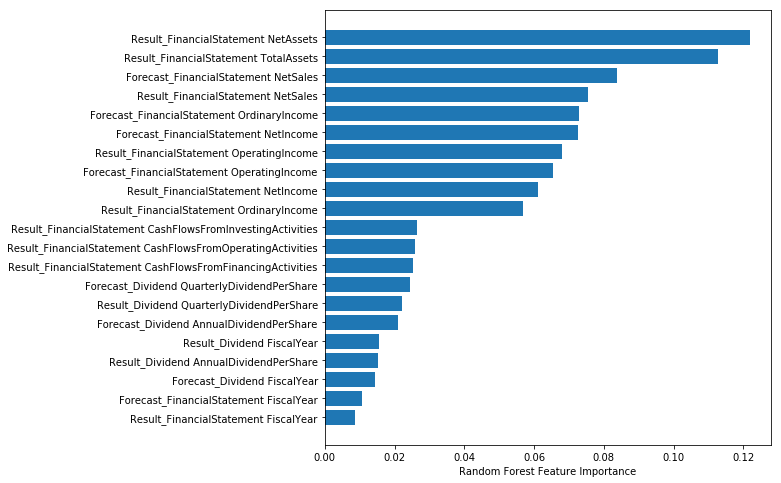

In [40]:
rf = pred_model

# プロット
fig, ax = plt.subplots(figsize=(8, 8))
sorted_idx = rf.feature_importances_.argsort()
ax.barh(fundamental_cols[sorted_idx], rf.feature_importances_[sorted_idx])
ax.set_xlabel("Random Forest Feature Importance")

# SHAP分析

### Chapter 2.11.2

In [41]:
# xgboostモデル学習　
sample_model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(train_X["label_high_20"], label=train_y["label_high_20"]), 100)

model_output = "margin" has been renamed to model_output = "raw"


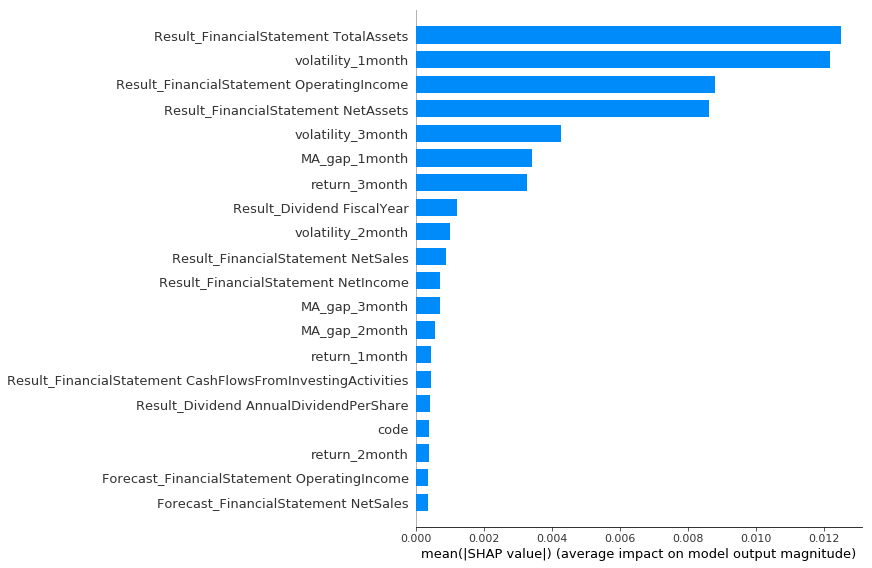

In [42]:
shap.initjs()

explainer = shap.TreeExplainer(model=sample_model, feature_perturbation='tree_path_dependent', model_output='margin')

shap_values = explainer.shap_values(X=train_X["label_high_20"])

shap.summary_plot(shap_values, train_X["label_high_20"], plot_type="bar")

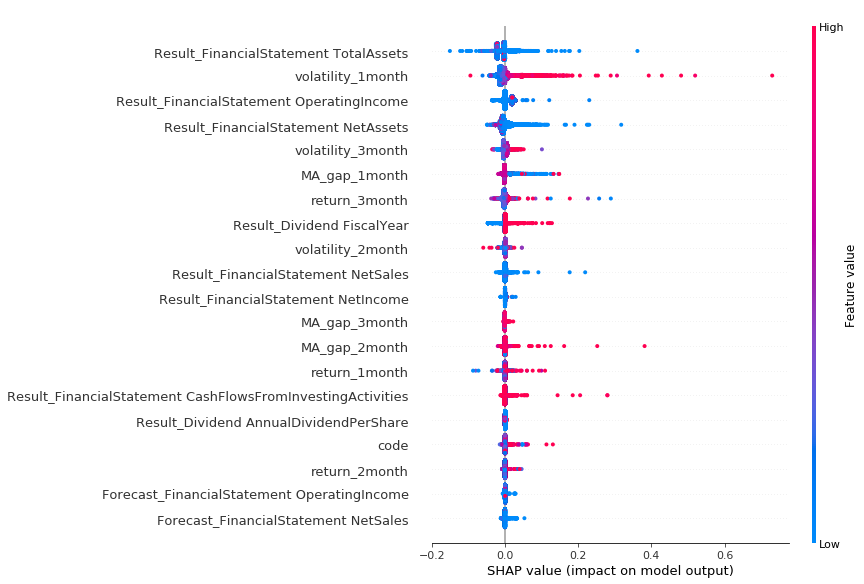

In [43]:
shap.summary_plot(shap_values, train_X["label_high_20"])

# check all the patterns

### Chapter 2.12.1

In [44]:
# ここで探索するモデルを定義します。
models = {
    "rf": RandomForestRegressor,
    "extraTree": ExtraTreesRegressor,
    "gbr": GradientBoostingRegressor,
}

all_results = dict()

# ここでモデルに入れるデータセットを定義します。
columns = {
    "fundamental_only": fundamental_cols,
    "return_only": returns_cols,
    "technical_only": technical_cols,
    "fundamental+technical": list(fundamental_cols) + list(technical_cols),
}

for model in tqdm(models.keys()):
    all_results[model] = dict()
    for col in tqdm(columns.keys()):
        result = dict()
        for label in tqdm(labels):
            if len(test_X[label][columns[col]]) > 0:
                pred_model = models[model](random_state=0)
                pred_model.fit(train_X[label][columns[col]].values, train_y[label])
                result[label] = test_X[label][["code"]].copy()
                result[label]["datetime"] = test_X[label][columns[col]].index
                result[label]["predict"] = pred_model.predict(test_X[label][columns[col]])
                result[label]["predict_dir"] = np.sign(result[label]["predict"])
                result[label]["actual"] = test_y[label].values
                result[label]["actual_dir"] = np.sign(result[label]["actual"])
                result[label].dropna(inplace=True)

        all_results[model][col] = result

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.


In [45]:
results = []
for model in all_results.keys():
    for col in all_results[model]:
        tmp = pd.concat(all_results[model][col])
        tmp["model"] = model
        tmp["feature"] = col
        results.append(tmp)
results = pd.concat(results)
results["label"] = [x[0] for x in results.index]
results["id"] = results["code"].astype(str)+results["datetime"].dt.strftime('%Y%m%d')
results.head(5)

code   datetime   predict  predict_dir   actual  actual_dir model           feature  \
              datetime                                                                                          
label_high_10 2019-02-08  1301 2019-02-08  0.109417          1.0  0.07143         1.0    rf  fundamental_only   
              2019-05-13  1301 2019-05-13  0.095722          1.0  0.04379         1.0    rf  fundamental_only   
              2019-08-02  1301 2019-08-02  0.055176          1.0  0.00498         1.0    rf  fundamental_only   
              2019-11-05  1301 2019-11-05  0.172141          1.0  0.00841         1.0    rf  fundamental_only   
              2020-02-07  1301 2020-02-07  0.113166          1.0  0.01212         1.0    rf  fundamental_only   

                                  label            id  
              datetime                                 
label_high_10 2019-02-08  label_high_10  130120190208  
              2019-05-13  label_high_10  130120190513  
              2019-08-02  label_high_10  130120190802  
              2019-11-05  label_high_10  130120191105  
              2020-02-07  label_high_10  130120200207

### Chapter2.12.2

In [46]:
all_metrics = []

for feature in columns:
    matrix = dict()
    for model in models:
        for label in labels:
            tmp_df = results[(results["model"] == model) & (results["label"] == label) & (results["feature"] == feature)]
            rmse = np.sqrt(mean_squared_error(tmp_df["predict"], tmp_df["actual"]))
            accuracy = accuracy_score(tmp_df["predict_dir"], tmp_df["actual_dir"])
            corr = np.corrcoef(tmp_df["actual"], tmp_df["predict"])[0, 1]
            spearman_corr = spearmanr(tmp_df["actual"], tmp_df["predict"])[0]
            matrix[label] = [rmse, accuracy, spearman_corr,corr, corr**2, feature, model, tmp_df.shape[0]]
        res = pd.DataFrame.from_dict(matrix).T
        res.columns = ["RMSE","accuracy","spearman_corr","corr","R^2 score","feature", "model", "# of samples"]
        all_metrics.append(res)
all_metrics = pd.concat(all_metrics)
all_metrics.reset_index()

,index,RMSE,accuracy,spearman_corr,corr,R^2 score,feature,model,# of samples
0,label_low_20,0.106318,0.859972,0.0810929,0.0899927,0.00809869,fundamental_only,rf,32515
1,label_high_10,0.13105,0.773473,0.0833374,0.120663,0.0145596,fundamental_only,rf,32729
2,label_high_20,0.184459,0.825742,0.0872271,0.12268,0.0150504,fundamental_only,rf,32515
3,label_low_10,0.0785598,0.827034,0.080455,0.0852954,0.00727531,fundamental_only,rf,32729
4,label_high_5,0.104222,0.718203,0.0817226,0.119532,0.014288,fundamental_only,rf,32747
5,label_low_5,0.0696151,0.78853,0.083953,0.0851869,0.00725681,fundamental_only,rf,32747
6,label_low_20,0.107968,0.847024,0.0836284,0.0884287,0.00781963,fundamental_only,extraTree,32515
7,label_high_10,0.134118,0.768493,0.0362586,0.0713137,0.00508565,fundamental_only,extraTree,32729
8,label_high_20,0.190357,0.821805,0.0628612,0.0902237,0.00814031,fundamental_only,extraTree,32515
9,label_low_10,0.0808126,0.808213,0.0750035,0.0755273,0.00570438,fundamental_only,extraTree,32729


In [ ]:
numeric_cols = ["RMSE","accuracy","spearman_corr","corr","R^2 score"]
for col in numeric_cols:
    all_metrics[col] = all_metrics[col].astype(float)
agg = all_metrics.reset_index().groupby(["index","feature"]).agg("mean")
agg